# Redes neuronales 2017
## Trabajo práctico 2

In [126]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
df = pd.read_csv('tp2_training_dataset.csv', header=None)

X = df.iloc[:,1:]
y = df.iloc[:,0]

# partición del conjunto de datos en conjuntos de entrenamiento (90%) y prueba (10%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

In [ ]:
df[1:].max().hist(bins=range(10))
plt.yscale('log')
plt.xlabel('Cantidad de palabras por dimensión')
plt.ylabel('Dimensiones')
plt.savefig('histograma.pdf')

In [ ]:
df[0].value_counts(sort=False)

In [3]:
def lotes(X, y, n):
    if n < 1: n = len(X)
    
    for i in range(0, len(X), n):
        yield X[i:i+n], y[i:i+n]

        
def barajar(X, y):
    e = np.random.get_state()
    X = np.random.permutation(X)
    np.random.set_state(e)
    y = np.random.permutation(y)
    
    return X, y

## Parte 1

In [125]:
from sklearn.base import BaseEstimator

class NS(BaseEstimator):

    def __init__(self, inicialización=(-.1,.1), tamaño_lote=1, factor_aprendizaje=0.0001, épocas=100, salidas=3, regla='sanger'):
        self.inicialización = inicialización
        self.tamaño_lote = tamaño_lote
        self.factor_aprendizaje = factor_aprendizaje
        self.épocas = épocas
        self.salidas = salidas
        self.regla = regla.lower()
    
        if self.regla == 'sanger':
            self.f = lambda eta, X, Y, W: eta * (np.dot(X.T, Y) - np.dot(W, np.tril( np.dot(Y.T,Y) ) ) )
        elif self.regla == 'oja':
            self.f = lambda eta, X, Y, W: eta * np.dot( (X - np.dot(Y, W.T) ).T, Y)
        elif self.regla == 'hebb':
            self.f = lambda eta, X, Y, W: eta * np.dot(X.T, Y)
    
    
    def fit(self, X, y):
        # asegurarse de que 'y' sea 2D
        if y.ndim == 1:
            y = y.reshape((-1, 1))
        
        entradas = X.shape[1]
        
        forma = (entradas, self.salidas)
        self.W = np.random.uniform(low=self.inicialización[0], high=self.inicialización[1], size=forma)
         
        eta = self.factor_aprendizaje
        
        for época in range(self.épocas):
            _X, _y = barajar(X, y)
            
            for lote_X, lote_y in lotes(_X, _y, self.tamaño_lote):
                Y = np.dot(lote_X, self.W)
                self.W += self.f(eta, lote_X, Y, self.W)
            
        return self

    
    def transform(self, X, y=None):
        return np.dot(X, self.W)
    
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)

In [5]:
def plot_ns(X_test, y_test):
    proyecciones = [( 60, 60),(150, 60),
                    ( 60,150),(240,240),]
    
    plt.figure(figsize=(5, 5))
    
    for i,(a,b) in enumerate(proyecciones):
        ax = plt.subplot(2,2,i+1, projection='3d')
        ax.scatter(xs=X_test[:,0],  ys=X_test[:,1],  zs=X_test[:,2],  c=y_test,  marker='.', lw=0)
        ax.view_init(a, b)
    
        #ax.set_xlabel('x')
        #ax.set_ylabel('y')
        #ax.set_zlabel('z')

        # Get rid of the panes                          
        #ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) 
        #ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) 
        #ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) 

        # Get rid of the spines                         
        ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) 
        ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) 
        ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    
        # Get rid of the ticks                          
        ax.set_xticks([])                               
        ax.set_yticks([])                               
        ax.set_zticks([])

In [130]:
def exp(save='/home/matias/redes-neuronales/tp2/hebb/', **args):
    rn = NS(**args)
    clf = make_pipeline(StandardScaler(), rn)
    clf.fit(X_train, y_train)

    plot_ns(clf.transform(X_test), y_test)
    plt.suptitle('Regla de {} $T={}$ $\eta={}$'.format(rn.regla.capitalize(), rn.épocas, rn.factor_aprendizaje))
    plt.savefig(save + '{}_T{}_eta{}.pdf'.format(rn.regla, rn.épocas, rn.factor_aprendizaje))

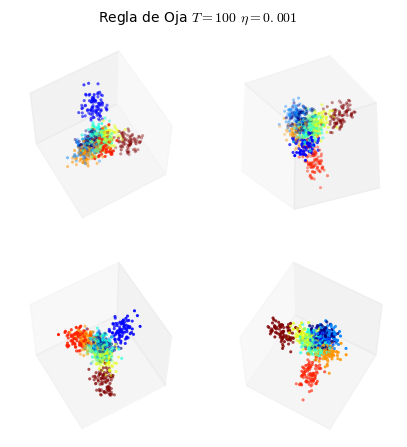

In [131]:
exp(regla='oja', épocas=100, factor_aprendizaje=.001)

---

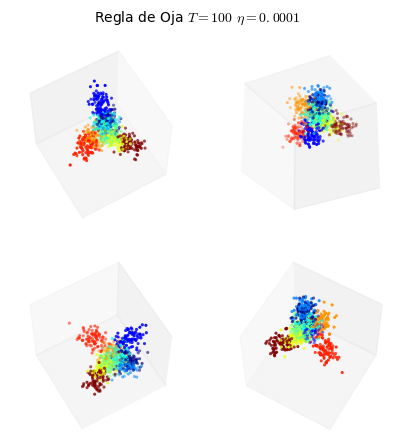

In [132]:
exp(regla='oja', épocas=100, factor_aprendizaje=.0001)

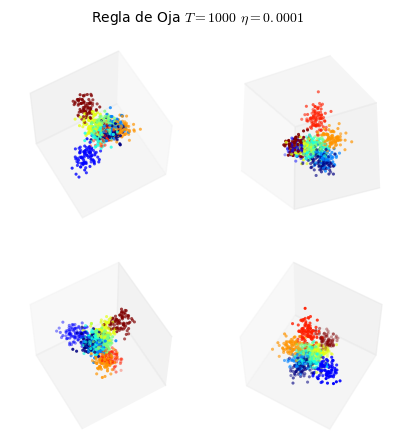

In [133]:
exp(regla='oja', épocas=1000, factor_aprendizaje=.0001)

---

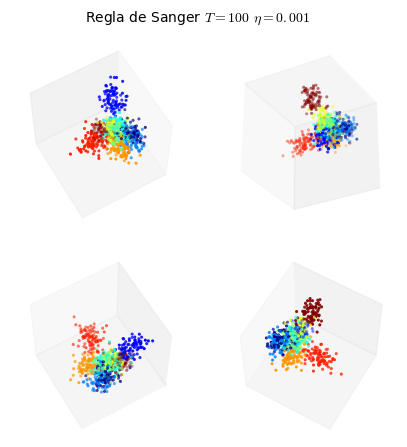

In [135]:
exp(regla='sanger', épocas=100, factor_aprendizaje=.001)

---

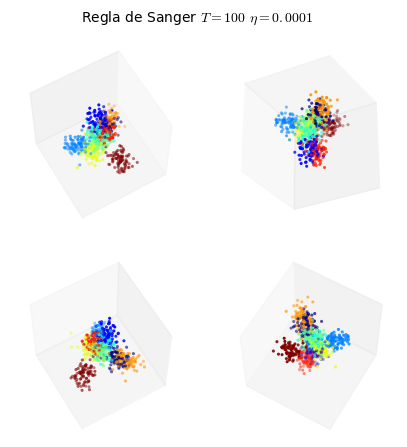

In [136]:
exp(regla='sanger', épocas=100, factor_aprendizaje=.0001)

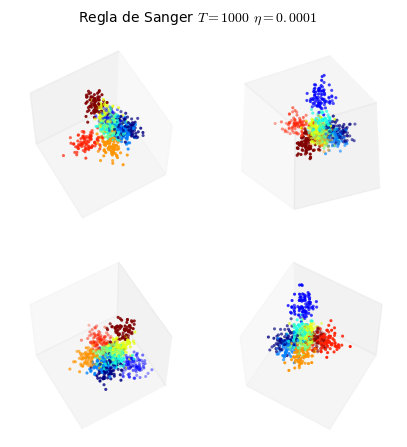

In [137]:
exp(regla='sanger', épocas=1000, factor_aprendizaje=.0001)

## Parte 2

In [138]:
from itertools import product
from collections import Counter
from sklearn.base import BaseEstimator
from scipy.spatial import distance

class SOM(BaseEstimator):

    def __init__(self, inicialización=(-1,1), factor_aprendizaje=1, épocas=10, lado=6, fwhm=1, alto=None, medida_distancia=distance.euclidean):
        self.inicialización = inicialización
        self.factor_aprendizaje = factor_aprendizaje
        self.épocas = épocas
        self.lado = lado
        self.fwhm = fwhm
        self.alto = alto or épocas
        self.medida_distancia = medida_distancia
        
    
    def fit(self, X, y):
        # factor de aprendizaje
        eta = lambda eta_inicial, t, T: eta_inicial * (T-t) / T
        # función de proximidad
        theta = lambda x1, x2, sigma: np.exp(-0.5 * (distance.euclidean(x1, x2) / sigma)**2 )

        # asegurarse de que 'y' sea 2D
        if y.ndim == 1:
            y = y.reshape((-1, 1))
        
        entradas = X.shape[1]
        W = lambda: np.random.uniform(low=self.inicialización[0], high=self.inicialización[1], size=entradas)
        self.nodos = [{'V':np.array((x,y)), 'W':np.random.choice(2, entradas, p=(.9,.1)).astype(float)} for x,y in product(range(self.lado), range(self.lado))]
        
        for época in range(self.épocas):
            if época == self.alto:
                break

            _X, _y = barajar(X, y)
    
            for x, lote_y in lotes(_X, _y, 1):
                x = x.reshape(-1)
                bmd = float('inf')
                bmu = None
    
                # selección de la BMU (best matching unit) a partir de la BMD (best matching distance)
                for nodo in self.nodos:
                    distancia = self.medida_distancia(x, nodo['W'])
    
                    if distancia < bmd:
                        bmd = distancia
                        bmu = nodo
    
            # actualización de los pesos
            for nodo in self.nodos:
                nodo['W'] += eta(self.factor_aprendizaje, época, self.épocas) * \
                             theta(bmu['V'], nodo['V'], self.fwhm / 2.35) * (x - nodo['W'])
                
        return self
    
                 
    def transform(self, X, y):
        for nodo in self.nodos: nodo['contador'] = Counter()
        
        for x, _y in lotes(X, y, 1):
            x = x.reshape(-1)
            bmd = float('inf')
            bmu = None
    
            # selección del best matching unit
            for nodo in self.nodos:
                distancia = self.medida_distancia(x, nodo['W'])
    
                if distancia < bmd:
                    bmd = distancia
                    bmu = nodo
        
            bmu['contador'][_y.values[0]] += 1
        
        for nodo in self.nodos:
            if len(nodo['contador']) > 0:
                nodo['categoría'] = nodo['contador'].most_common()[0][0]
            else:
                nodo['categoría'] = np.nan
        
        return self.nodos
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)

In [139]:
def plot_som(nodos, size=(4,4)):
    plt.figure(figsize=size)
    
    lado = int(np.sqrt(len(nodos)))
    matriz = np.zeros((lado,lado))

    for nodo in nodos:
        x = nodo['V'][0]
        y = nodo['V'][1]
        matriz[x][y] = nodo['categoría']
    
    ax = plt.gca()
    ax.matshow(matriz)
    ax.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labeltop='off')                         

In [140]:
def plot_som_comp(nodos, size=(4, 4)):
    plt.figure(figsize=size)

    lado = int(np.sqrt(len(nodos)))
    matriz = np.zeros((lado,lado))
    
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        
        for nodo in nodos:
            x = nodo['V'][0]
            y = nodo['V'][1]
            matriz[x][y] = nodo['contador'][i+1]
                       
        ax.matshow(matriz, cmap='Greys')
        ax.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labeltop='off')            

In [141]:
def experimento(save='/home/matias/redes-neuronales/tp2/som/', sanger=0, plot=plot_som, **args):
    som = SOM(**args)
    
    if sanger > 0:
        ns = NS(regla='sanger', épocas=1000, factor_aprendizaje=.0001, salidas=sanger)
        
        vars = (ns.salidas, som.lado, som.lado, som.alto, som.factor_aprendizaje, som.fwhm)
        title = 'Sanger $s={}$ | SOM ${} * {}$ $T={}$ $\eta_0={}$ $k={}$'.format(*vars)
        filename = 'sanger{}_som{}x{}_T{}_eta{}_k{}.pdf'.format(*vars)
        
        est = make_pipeline(
            StandardScaler(),
            ns,
            som,
        )
    else:
        vars = (som.lado, som.lado, som.alto, som.factor_aprendizaje, som.fwhm)
        title = 'SOM ${} * {}$ $T={}$ $\eta_0={}$ $k={}$'.format(*vars)
        filename = 'som{}x{}_T{}_eta{}_k{}.pdf'.format(*vars)
        
        est = make_pipeline(
            #StandardScaler(with_std=False),
            som,
        )

    plot(est.fit_transform(X.values, y))

    if plot == plot_som:
        plt.title(title)
    else:
        plt.suptitle(title)
        
    if save:
        plt.savefig(save + plot.__name__ + '_' + filename)

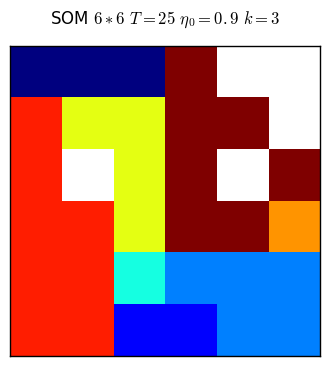

In [453]:
np.random.seed(9)
experimento(factor_aprendizaje=.9, épocas=100, alto=25, fwhm=3, medida_distancia=distance.cosine)

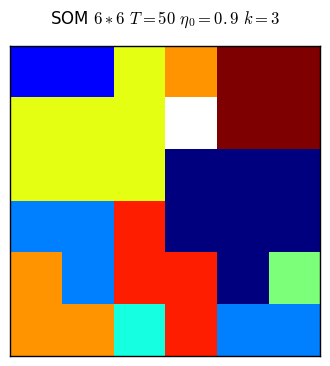

In [454]:
np.random.seed(9)
experimento(factor_aprendizaje=.9, épocas=100, alto=50, fwhm=3, medida_distancia=distance.cosine)

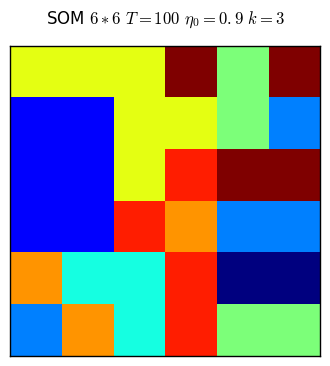

In [455]:
np.random.seed(9)
experimento(factor_aprendizaje=.9, épocas=100, fwhm=3, medida_distancia=distance.cosine)

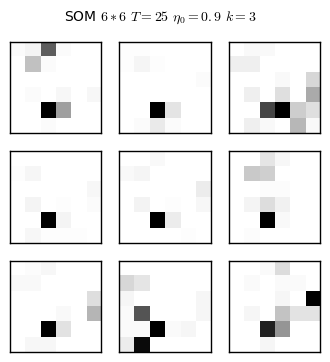

In [456]:
np.random.seed(9)
experimento(factor_aprendizaje=.9, épocas=100, alto=25, fwhm=3, medida_distancia=distance.cosine, plot=plot_som_comp)

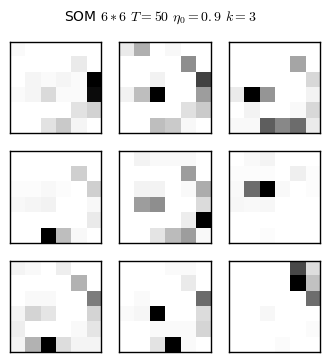

In [457]:
np.random.seed(9)
experimento(factor_aprendizaje=.9, épocas=100, alto=50, fwhm=3, medida_distancia=distance.cosine, plot=plot_som_comp)

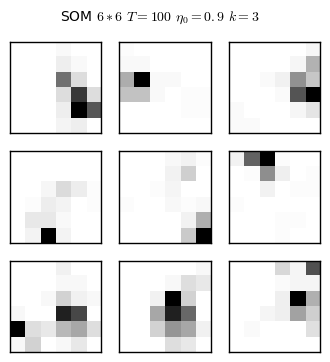

In [458]:
np.random.seed(9)
experimento(factor_aprendizaje=.9, épocas=100, fwhm=3, medida_distancia=distance.cosine, plot=plot_som_comp)

---

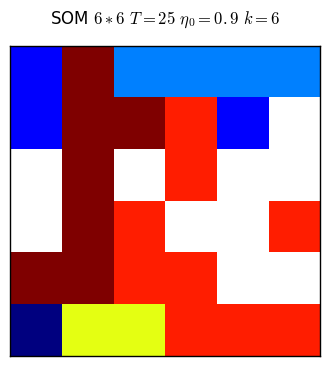

In [459]:
np.random.seed(9)
experimento(factor_aprendizaje=.9, épocas=100, alto=25, fwhm=6, medida_distancia=distance.cosine)

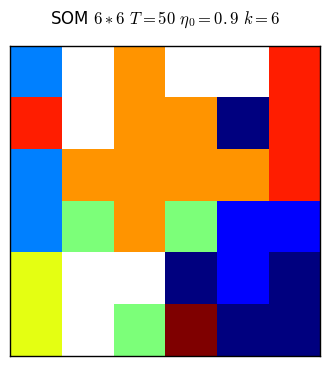

In [460]:
np.random.seed(9)
experimento(factor_aprendizaje=.9, épocas=100, alto=50, fwhm=6, medida_distancia=distance.cosine)

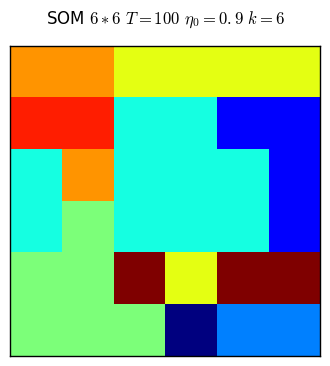

In [461]:
np.random.seed(9)
experimento(factor_aprendizaje=.9, épocas=100, fwhm=6, medida_distancia=distance.cosine)

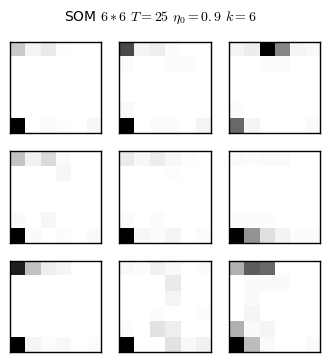

In [462]:
np.random.seed(9)
experimento(factor_aprendizaje=.9, épocas=100, alto=25, fwhm=6, medida_distancia=distance.cosine, plot=plot_som_comp)

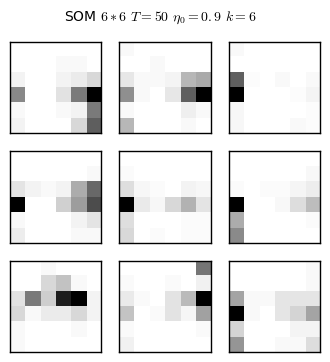

In [463]:
np.random.seed(9)
experimento(factor_aprendizaje=.9, épocas=100, alto=50, fwhm=6, medida_distancia=distance.cosine, plot=plot_som_comp)

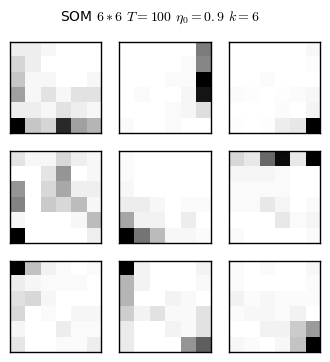

In [464]:
np.random.seed(9)
experimento(factor_aprendizaje=.9, épocas=100, fwhm=6, medida_distancia=distance.cosine, plot=plot_som_comp)

---

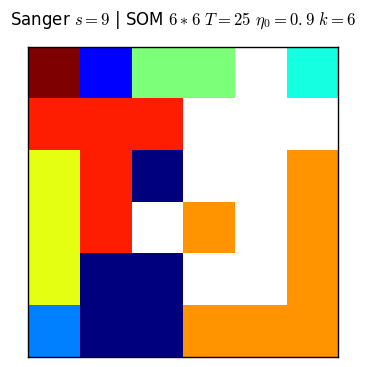

In [142]:
np.random.seed(9)
experimento(factor_aprendizaje=.9, épocas=100, alto=25, fwhm=6, sanger=9)

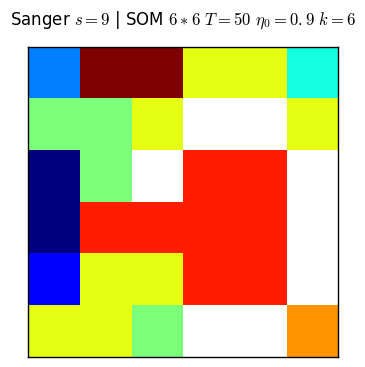

In [143]:
np.random.seed(9)
experimento(factor_aprendizaje=.9, épocas=100, alto=50, fwhm=6, sanger=9)

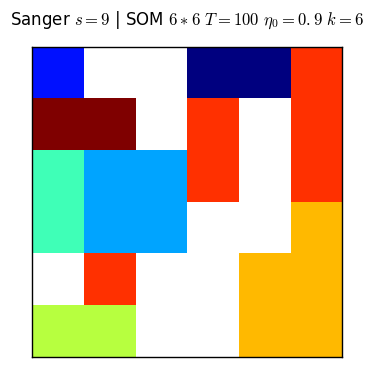

In [144]:
np.random.seed(9)
experimento(factor_aprendizaje=.9, épocas=100, fwhm=6, sanger=9)

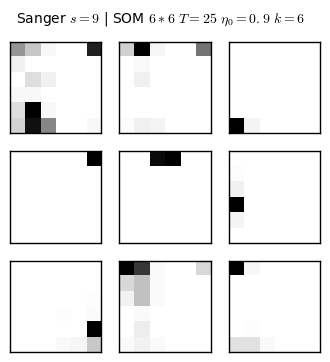

In [145]:
np.random.seed(9)
experimento(factor_aprendizaje=.9, épocas=100, alto=25, fwhm=6, sanger=9, plot=plot_som_comp)

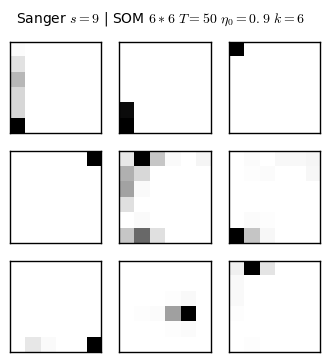

In [146]:
np.random.seed(9)
experimento(factor_aprendizaje=.9, épocas=100, alto=50, fwhm=6, sanger=9, plot=plot_som_comp)

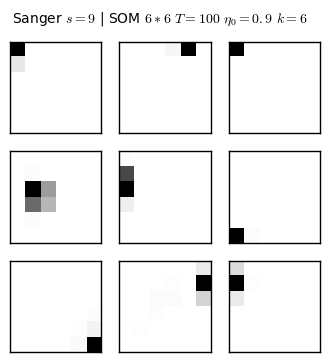

In [147]:
np.random.seed(9)
experimento(factor_aprendizaje=.9, épocas=100, fwhm=6, sanger=9, plot=plot_som_comp)

---

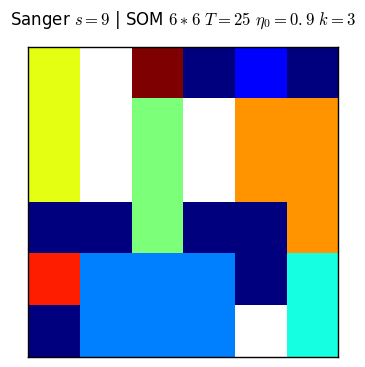

In [148]:
np.random.seed(9)
experimento(factor_aprendizaje=.9, épocas=100, alto=25, fwhm=3, sanger=9)

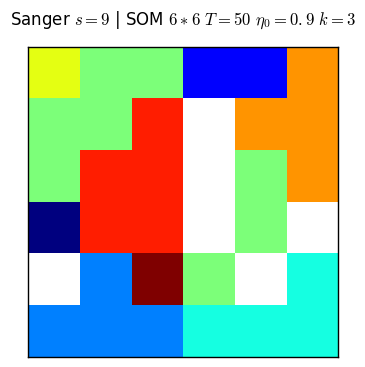

In [149]:
np.random.seed(9)
experimento(factor_aprendizaje=.9, épocas=100, alto=50, fwhm=3, sanger=9)

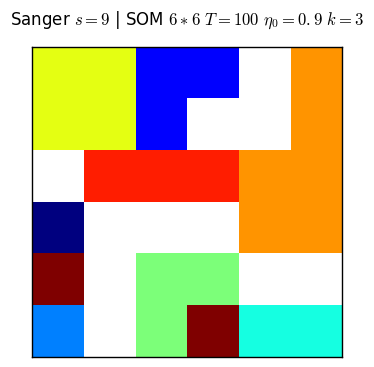

In [150]:
np.random.seed(9)
experimento(factor_aprendizaje=.9, épocas=100, fwhm=3, sanger=9)

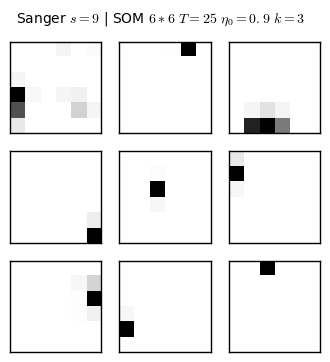

In [151]:
np.random.seed(9)
experimento(factor_aprendizaje=.9, épocas=100, alto=25, fwhm=3, sanger=9, plot=plot_som_comp)

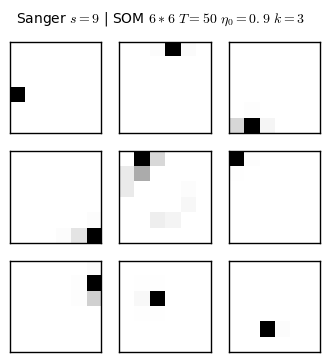

In [152]:
np.random.seed(9)
experimento(factor_aprendizaje=.9, épocas=100, alto=50, fwhm=3, sanger=9, plot=plot_som_comp)

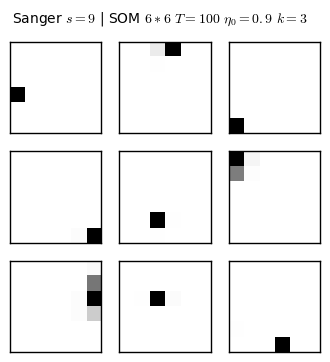

In [153]:
np.random.seed(9)
experimento(factor_aprendizaje=.9, épocas=100, fwhm=3, sanger=9, plot=plot_som_comp)